In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#path = '/home/gsm/Documents/extras/kaggle/petfinder/'
#df = pd.read_csv(path+'train/train.csv')

In [3]:
with open('dump_data/train_proc','rb') as f:
    df = pickle.load(f)

In [4]:
tdf = df.copy()

target = ['AdoptionSpeed']

#num_columns = ['Age']
text_features = ['Description', 'metadata_annots_top_desc', 'sentiment_entities']

categorical_features = [#TODO CHECK if it matters 'main_breed_BreedName', 'second_breed_BreedName',
                       'Breed1','Breed2',
                        'Type','Gender','Dewormed','Vaccinated','RescuerID_COUNT']

to_drop_features = ['PetID', 'Name', 'RescuerID',
                   'Color1','Color2','Color3',
                   #'Breed1','Breed2',
                   'main_breed_BreedName', 'second_breed_BreedName',
                   'MaturitySize','FurLength']

numeric_features = list(set(tdf.columns.values) -set(target) - set(text_features) - set(categorical_features) - set(to_drop_features))

In [5]:
rates = (df.AdoptionSpeed.value_counts()/df.AdoptionSpeed.value_counts().sum()).values[::-1]
rates = np.cumsum(rates)

In [6]:
rescuer_count = tdf.groupby(['RescuerID'])['PetID'].count().reset_index()
rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']
tdf = tdf.merge(rescuer_count, how='left', on='RescuerID')

for c in text_features:
    tdf.loc[:, c].fillna('<MISSING>',inplace=True)


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator,RegressorMixin,TransformerMixin
from sklearn.preprocessing import Binarizer,MinMaxScaler,StandardScaler
from sklearn.preprocessing import OneHotEncoder,QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC,SVR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LinearRegression,Lasso

from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier,XGBRegressor

from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score,make_scorer

from pf_models import *

In [9]:
#model = LGBMClassifier()
early_stop = 500
verbose_eval = 100
num_rounds = 10000
n_splits = 5

params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
          'max_depth': 9,
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': 1,
          'data_random_seed': 17}

model = LGBMRegressor(early_stop = 500,
verbose_eval = 100,
num_rounds = 1000,
n_splits = 5,silent=False,**params)

In [23]:
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

text_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('tf-idf', TfidfVectorizer(ngram_range=(1,2),min_df=2)),
    ('svd',TruncatedSVD(n_components=10))
    #('vect',CountVectorizer())ngram_range=(1,2),token_pattern=r'(?u)\b\w+\b',
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        *[('txt'+f, text_transformer,f) for f in text_features]
    ],
    remainder='drop')


clf = Pipeout(mode='class',rates=rates,steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', vtc)])

X = tdf.drop('AdoptionSpeed', axis=1)
y = tdf['AdoptionSpeed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)

clf.fit(X_train, y_train)

Pipeout(memory=None, mode=None,
    rates=array([0.02735, 0.23344, 0.45081, 0.72007, 1.     ]),
    steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))]), ['Quantity', 'metadata_metadata_crop_importa...mple=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbose_eval=100,
       verbosity=1))])

In [24]:
yh = clf.predict(X_test)

In [25]:
optR = OptimizedRounder()
optR.fit(yh, y_test)
thr = optR.coefficients()
print(thr)

[0.44950666 2.01516561 2.44954123 2.76716334]


In [26]:
yh = [to_bins(y,thr) for y in yh]

0.42214443829645154

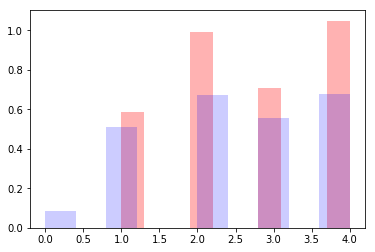

In [27]:
plt.hist(yh,normed=True,alpha=.3,color='r')
plt.hist(y_test,normed=True,alpha=.2,color='b');
#plt.hist(y_test,normed=True,alpha=.2,color='g');
cohen_kappa_score(y_test,yh,weights='quadratic')

In [28]:
print(classification_report(yh,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.34      0.39      0.36       526
           2       0.36      0.33      0.34       893
           3       0.29      0.30      0.29       637
           4       0.61      0.53      0.57       943

   micro avg       0.40      0.40      0.40      2999
   macro avg       0.32      0.31      0.31      2999
weighted avg       0.42      0.40      0.41      2999



In [47]:
class A(BaseEstimator):
    def fit(self,*args,**kwargs):
        super().fit(*args,**kwargs)
    def predict(self,*args,**kwargs):
        pass
    def get_params(self,*args,**kwargs):
        super().get_params(*args,**kwargs)
        

In [52]:
a = A()

In [53]:
scorer = make_scorer(cohen_kappa_score,weights='quadratic')
score = cross_val_score(a,X,y,cv=5,scoring=scorer)

AttributeError: 'NoneType' object has no attribute 'items'

In [21]:
score

array([0.42296292, 0.41263416, 0.43217572, 0.435035  , 0.42646396])

In [22]:
score.mean()

0.42585435441244357

In [ ]:
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=n_splits, random_state=1337)


oof_train = np.zeros((X_train.shape[0]))
oof_test = np.zeros((X_test.shape[0], n_splits))


i = 0
for train_index, valid_index in kfold.split(X_train, X_train['AdoptionSpeed'].values):
    
    X_tr = X_train.iloc[train_index, :]
    X_val = X_train.iloc[valid_index, :]
    
    y_tr = X_tr['AdoptionSpeed'].values
    X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)
    
    y_val = X_val['AdoptionSpeed'].values
    X_val = X_val.drop(['AdoptionSpeed'], axis=1)
    
    print('\ny_tr distribution: {}'.format(Counter(y_tr)))
    
    d_train = lgb.Dataset(X_tr, label=y_tr)
    d_valid = lgb.Dataset(X_val, label=y_val)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    oof_train[valid_index] = val_pred
    oof_test[:, i] = test_pred
    
    i += 1

In [ ]:
sub_df = pd.DataFrame()
sub_df['PetID'] = X_test['PetID']
sub_df['AdoptionSpeed'] = yh
sub_df.to_csv('submission.csv', index=False)